In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from PIL import Image

In [3]:
stepdata=1 # sparsify data before computing
k=21 # choose number of clusters
maxiterations=1000 # number of iterations
whichalgo=1 # which algorithm
whichimage=0 # which image to start with
doubleprecision=0 # if double precision or not

In [5]:
# also control "step" that sets how much of final plot to show (too many points takes too long even if kmeans if fast)
if whichimage==0:
    logo = Image.open("kmeans_data/h2o-logo.jpg");step=13
if whichimage==1: 
    logo = Image.open("kmeans_data/low_h2o-logo.jpg");step=2
if whichimage==2:
    logo = Image.open("kmeans_data/lowlow_h2o-logo.jpg");step=1

In [6]:
data = array(logo)

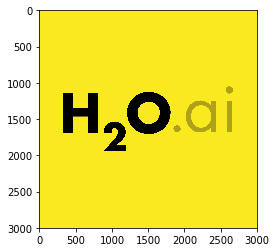

In [7]:
imshow(data)

In [8]:
data.shape

(3000, 3000, 3)

In [9]:
N = int(data.shape[0]*data.shape[1]/2)
seed(777)
space = concatenate((randint(0, data.shape[0], N)[:, newaxis], randint(0, data.shape[1], N)[:, newaxis]), axis=1)

In [10]:
uspace = zeros_like(data)
uspace[space[:, 0], space[:, 1]] = 1

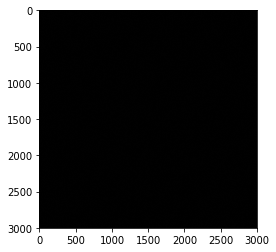

In [11]:
imshow(uspace)

In [12]:
dots = data * uspace

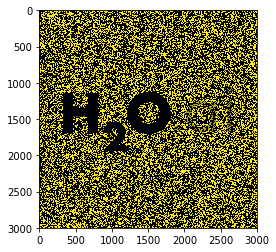

In [13]:
imshow(dots)

In [14]:
dataset = vstack(nonzero(dots)).T

In [15]:
#numpy.set_printoptions(threshold=numpy.nan)
#print(dataset)

In [16]:
dataset = dataset[::stepdata]    
np.isfortran(dataset)
print(type (dataset))
print(dataset.shape)

rows=np.shape(dataset)[0]
print("rows=%d" % (rows))
labels = np.random.randint(rows, size=rows) % k

if doubleprecision==1:
    dataset = dataset.astype(float64)
    labels = labels.astype(float32)
else:
    dataset = dataset.astype(float32)
    labels = labels.astype(float32)

for i in range(k):
    print(i in labels)

<class 'numpy.ndarray'>
(10116514, 3)
rows=10116514
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [17]:
print(labels)
print(dataset)

[  2.   2.  10. ...,   0.   8.  11.]
[[  0.00000000e+00   4.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   4.00000000e+00   1.00000000e+00]
 [  0.00000000e+00   4.00000000e+00   2.00000000e+00]
 ..., 
 [  2.99900000e+03   2.99900000e+03   0.00000000e+00]
 [  2.99900000e+03   2.99900000e+03   1.00000000e+00]
 [  2.99900000e+03   2.99900000e+03   2.00000000e+00]]


In [19]:
import h2ogpuml
rows=np.shape(dataset)[0]
np.random.seed(1234)
n_gpus=1
init_from_labels=False # so auto-generate initial centroids, no need to initialize labels or centroids
model = h2ogpuml.KMeans(n_gpus=n_gpus, n_clusters=k, tol=1e-7, max_iter=maxiterations,init_from_labels=init_from_labels)
%time model.fit(dataset, labels)
cents = model.cluster_centers_
asses = model.predict(dataset)
# 14s on 1 titanX pascal with stepdata=1 , k=21 , maxiterations=1000 , whichalgo=1 , whichimage=0
# 26s on 1 titanX maxwell with stepdata=1 , k=21 , maxiterations=1000 , whichalgo=1 , whichimage=0
# 4s on 4 titanX pascals with stepdata=1 , k=21 , maxiterations=1000 , whichalgo=1 , whichimage=0



CPU times: user 39.2 s, sys: 6.83 s, total: 46 s
Wall time: 46 s


In [20]:
print(type (dataset))

<class 'numpy.ndarray'>


In [21]:
print(cents)

[[  1.80400903e+03   2.97122284e+02   1.00013149e+00]
 [  2.61832324e+03   2.71294141e+03   1.00000191e+00]
 [  2.65907397e+03   1.45619263e+03   1.00000215e+00]
 [  2.59740771e+03   2.74574432e+02   1.00000191e+00]
 [  2.71922900e+03   2.07171045e+03   1.00000226e+00]
 [  1.04171423e+03   2.64535645e+03   1.00000179e+00]
 [  1.79651489e+03   2.73156592e+03   1.00000000e+00]
 [  1.01618597e+03   3.43130157e+02   9.99219418e-01]
 [  1.44647278e+03   1.16566809e+03   1.00183809e+00]
 [  1.50277051e+03   2.11303125e+03   9.99892056e-01]
 [  2.10938501e+03   8.48640625e+02   1.00043702e+00]
 [  3.15969482e+02   1.50722034e+03   1.00000203e+00]
 [  3.36468719e+02   2.14685498e+03   1.00000215e+00]
 [  2.72180249e+03   8.57200806e+02   1.00000238e+00]
 [  2.02394751e+03   1.55886938e+03   1.00020552e+00]
 [  2.14317358e+03   2.20630615e+03   1.00000226e+00]
 [  3.09527039e+02   8.65559875e+02   1.00000226e+00]
 [  3.52098145e+02   2.72149683e+03   1.00000215e+00]
 [  8.79213623e+02   1.08258

In [22]:
print(asses)

[19 19 19 ...,  1  1  1]


In [23]:
np.ndarray.flatten(asses)

array([19, 19, 19, ...,  1,  1,  1], dtype=int32)

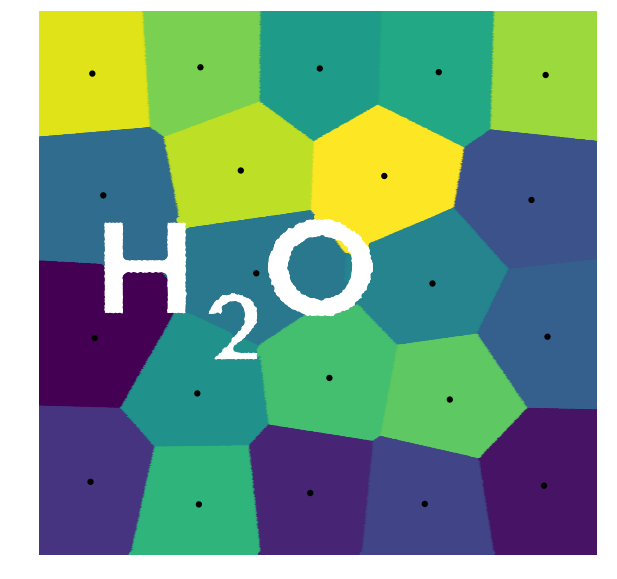

In [24]:
rcParams["figure.figsize"] = (10, 10)
scatter(dataset[::step, 1], dots.shape[0] - dataset[::step, 0], c=asses[::step], edgecolors="none")
scatter(cents[:, 1], dots.shape[0] - cents[:, 0], c="black", s=40, edgecolors="none")
xlim((0, dots.shape[1]))
ylim((0, dots.shape[0]))
axis("off")
savefig("sourced.png", transparent=True, bbox_inches=0, pad_inches=0)